[[580. 512.]
 [605. 510.]
 [624. 511.]
 [646. 511.]
 [663. 512.]
 [675. 515.]
 [694. 514.]]


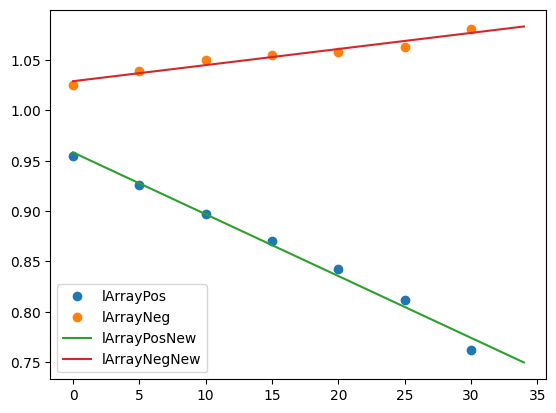

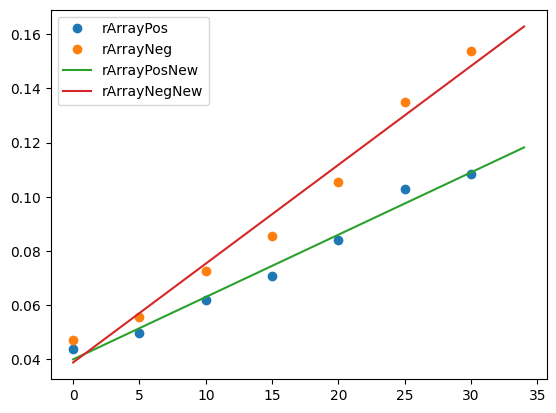

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import mplcursors
from helper_funcs import *
from scipy import signal
from scipy.optimize import curve_fit
from scipy.optimize import fsolve


epsilonArray = np.load('output/outputEpsilon.npy')
xiPrimeNegArray = np.load('output/outputXiNeg.npy')
xiPrimePosArray = np.load('output/outputXiPos.npy')
centerArray = np.load('output/outputCenter.npy',allow_pickle=True)
print(centerArray)
radiusArray = np.load('output/outputRadius.npy')

rArrayPos = np.zeros(len(centerArray))
rArrayNeg = np.zeros(len(centerArray))

lArrayPos = np.zeros(len(centerArray))
lArrayNeg = np.zeros(len(centerArray))

for i in range(len(centerArray)):
    theta = 90 - xiPrimePosArray[5*i]
    epsilon = epsilonArray[5*i]
    chi = 180 - epsilon - theta
    s = np.sin(np.deg2rad(theta))/np.sin(np.deg2rad(chi))

    xValue, yValue = centerArray[i][0], centerArray[i][1]
    xValue = xValue - 512
    yValue = yValue - 512

    xValue = xValue*45/512
    yValue = yValue*45/512

    epsilonPrime = np.sqrt(xValue**2 + yValue**2)

    r =  s*np.tan(np.deg2rad(epsilon - epsilonPrime))
    rArrayPos[i] = r

    l = np.sqrt(r**2 + s**2)
    lArrayPos[i] = l

for i in range(len(centerArray)):
    theta = 90 - xiPrimeNegArray[5*i]
    epsilon = epsilonArray[5*i]
    chi = 180 - epsilon - theta
    s = np.sin(np.deg2rad(theta))/np.sin(np.deg2rad(chi))

    xValue, yValue = centerArray[i]
    xValue = xValue - 512
    yValue = yValue - 512

    xValue = xValue*45/512
    yValue = yValue*45/512

    epsilonPrime = np.sqrt(xValue**2 + yValue**2)
    
    r =  s*np.tan(np.deg2rad(epsilon - epsilonPrime))
    rArrayNeg[i] = r

    l = np.sqrt(r**2 + s**2)
    lArrayNeg[i] = l




def linearFunc( x, m, b):
    return m*x + b

parameterslArrayNeg, covariance = curve_fit(linearFunc, np.arange(15,50,5), lArrayNeg)
parameterslArrayPos, covariance = curve_fit(linearFunc, np.arange(15,50,5), lArrayPos)

lArrayNegNew = linearFunc(np.arange(15,50), *parameterslArrayNeg)
lArrayPosNew = linearFunc(np.arange(15,50), *parameterslArrayPos)

parametersrArrayNeg, covariance = curve_fit(linearFunc, np.arange(15,50,5), rArrayNeg)
parametersrArrayPos, covariance = curve_fit(linearFunc, np.arange(15,50,5), rArrayPos)

rArrayNegNew = linearFunc(np.arange(15,50), *parametersrArrayNeg)
rArrayPosNew = linearFunc(np.arange(15,50), *parametersrArrayPos)


# for i in range(35):
#     surplus = (i - 5*(i // 5))/5

#     lArrayNegNew[i] = lArrayNeg[i//5]*(1 - surplus) + lArrayNeg[i//5 + 1]*(surplus)
#     lArrayPosNew[i] = lArrayPos[i//5]*(1 - surplus) + lArrayPos[i//5 + 1]*(surplus)

plt.figure()
plt.plot(np.arange(0,35,5),lArrayPos, 'o', label='lArrayPos')
plt.plot(np.arange(0,35,5),lArrayNeg, 'o', label='lArrayNeg')
plt.plot(lArrayPosNew, '-', label='lArrayPosNew')
plt.plot(lArrayNegNew, '-', label='lArrayNegNew')
plt.legend()
plt.figure()
plt.plot(np.arange(0,35,5),rArrayPos, 'o', label='rArrayPos')
plt.plot(np.arange(0,35,5),rArrayNeg, 'o', label='rArrayNeg')
plt.plot(rArrayPosNew, '-', label='rArrayPosNew')
plt.plot(rArrayNegNew, '-', label='rArrayNegNew')
plt.legend()
plt.show()






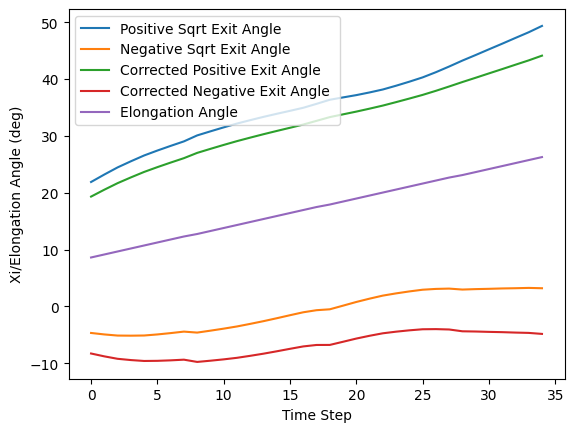

In [3]:
def trueXi(l, r, xiPrime, epsilon):

    d = np.sqrt(l**2 + 1 - 2*l*np.cos(np.deg2rad(epsilon)))
    
    func = lambda xi :  -xiPrime + xi + r/(r+d)*(180 - np.rad2deg(np.arcsin(np.cos(np.deg2rad(xi))/l)) - np.rad2deg(np.arccos(r/l)))

    return fsolve(func, xiPrime)


xiNegarray = trueXi(lArrayNegNew, rArrayNegNew, xiPrimeNegArray, epsilonArray)
xiPosarray = trueXi(lArrayPosNew, rArrayPosNew, xiPrimePosArray, epsilonArray)


fig, axs = plt.subplots()  
axs.plot(xiPrimePosArray, label='Positive Sqrt Exit Angle')
axs.plot(xiPrimeNegArray, label='Negative Sqrt Exit Angle') 
axs.plot(xiPosarray, label='Corrected Positive Exit Angle')
axs.plot(xiNegarray, label='Corrected Negative Exit Angle ')
axs.plot(epsilonArray, label='Elongation Angle')
axs.set_ylabel('Xi/Elongation Angle (deg)')
axs.set_xlabel('Time Step')
axs.legend(loc='upper left') 
plt.show()


    

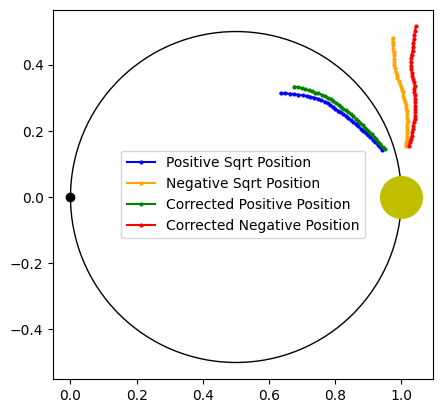

In [10]:
def calculatePositions(array, epsilonArray):
    positionArray = np.zeros((len(array),2))
    for i in range(len(array)):
        xi = array[i]
        epsilon = epsilonArray[i]
        cotXi = 1/np.tan(np.radians(xi))
        # print("cotXi = ", cotXi)
        tanE = np.tan(np.radians(epsilon))
        # print("tanE = ", tanE)
        x = cotXi/(tanE + cotXi)
        y = tanE*x
        positionArray[i] = np.array([x,y])
    
    return positionArray


axs = plt.subplot()
axs.plot(0,0, 'ko')
axs.plot(1,0, 'yo', markersize=30)

posPositionArray = calculatePositions(xiPrimePosArray, epsilonArray)
negPositionArray = calculatePositions(xiPrimeNegArray, epsilonArray)
posPositionArrayAdj = calculatePositions(xiPosarray, epsilonArray)
negPositionArrayAdj = calculatePositions(xiNegarray, epsilonArray)


axs.plot(posPositionArray[:,0],posPositionArray[:,1],color='blue', marker="o", label='Positive Sqrt Position', markersize=2)
axs.plot(negPositionArray[:,0],negPositionArray[:,1],color='orange', marker="o", label='Negative Sqrt Position', markersize=2)
axs.plot(posPositionArrayAdj[:,0],posPositionArrayAdj[:,1],color='green', marker="o", label='Corrected Positive Position', markersize=2)
axs.plot(negPositionArrayAdj[:,0],negPositionArrayAdj[:,1],color='red', marker="o", label='Corrected Negative Position', markersize=2)


thomson = plt.Circle((0.5, 0), 0.5, color='k', fill=False)
axs.add_patch(thomson)
axs.set_aspect('equal')
axs.legend()
plt.show()
